In [ ]:
import sys
sys.setrecursionlimit(10000)

import SimpleITK as sitk
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
# import graphviz
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model
from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from glob import glob
import os
from skimage import measure
import torchio as tio
import shutil

/home/dangnh/anaconda3/envs/mlmed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

In [58]:
frame = load_nifti_image("../database/training/patient023/patient023_frame01_gt.nii.gz")
print(type(frame))
print(frame.shape)


<class 'numpy.ndarray'>
(216, 256, 9)


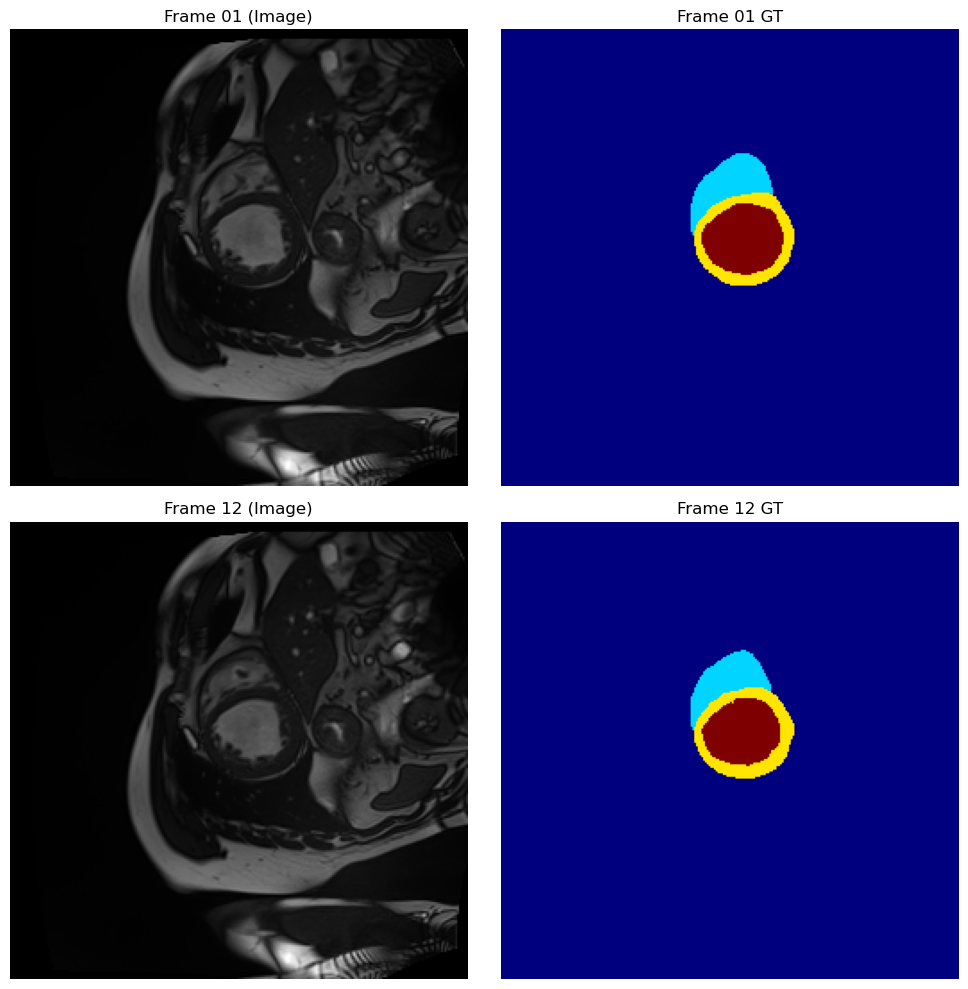

(256, 256, 10)


In [47]:

patient_folder = "../database/training/patient003"
frame_01_path = os.path.join(patient_folder, "patient003_frame01.nii.gz")
frame_01_gt_path = os.path.join(patient_folder, "patient003_frame01_gt.nii.gz")
frame_12_path = os.path.join(patient_folder, "patient003_frame15.nii.gz")
frame_12_gt_path = os.path.join(patient_folder, "patient003_frame15_gt.nii.gz")

frame_01 = load_nifti_image(frame_01_path)
frame_01_gt = load_nifti_image(frame_01_gt_path)
frame_12 = load_nifti_image(frame_12_path)
frame_12_gt = load_nifti_image(frame_12_gt_path)

slice_idx = frame_01.shape[-1] // 2  

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Frame 01 (likely ED)
axes[0, 0].imshow(frame_01[:, :, slice_idx], cmap="gray")
axes[0, 0].set_title("Frame 01 (Image)")

axes[0, 1].imshow(frame_01_gt[:, :, slice_idx], cmap="jet")
axes[0, 1].set_title("Frame 01 GT")

# Frame 12 (likely ES)
axes[1, 0].imshow(frame_12[:, :, slice_idx], cmap="gray")
axes[1, 0].set_title("Frame 12 (Image)")

axes[1, 1].imshow(frame_12_gt[:, :, slice_idx], cmap="jet")
axes[1, 1].set_title("Frame 12 GT")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()

print(frame_01.shape)

In [127]:
frame_12.shape

(232, 256, 10)

In [35]:
ROOT_DIR = "../database"
OUTPUT_DIR = "../processed"
TRAIN_DIR = os.path.join(ROOT_DIR, "training")
TEST_DIR = os.path.join(ROOT_DIR, "testing")

TARGET_SPACING = (1.25, 1.25, 10)  

SA_TARGET_SHAPE = (320, 320, 10)

In [36]:
def resample_nifti(image_path, target_spacing=TARGET_SPACING, is_label=False):
    """Resamples a NIfTI image to the target spacing, ensuring labels use nearest-neighbor interpolation."""
    image = sitk.ReadImage(image_path)
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    new_size = [int(round(osz * osp / nsp)) for osz, osp, nsp in zip(original_size, original_spacing, target_spacing)]
    interpolator = sitk.sitkNearestNeighbor if is_label else sitk.sitkLinear 
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(target_spacing)
    resampler.SetSize(new_size)
    resampler.SetInterpolator(interpolator)
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    
    resampled_image = resampler.Execute(image)
    
    print(f"✅ Resampled {image_path}: Original {original_size}, New {new_size}") 
    
    return resampled_image

In [37]:
def normalize_image(image_array):
    mean = image_array.mean()
    std = image_array.std()
    return (image_array - mean) / std if std > 0 else image_array

In [38]:
def resize_image(image_array, target_shape=SA_TARGET_SHAPE):
    print(f"Original shape before resizing: {image_array.shape}")  

    if image_array.shape != (target_shape[2], target_shape[1], target_shape[0]):
        print("Transposing image to (Z, Y, X) format before resizing.")
        image_array = np.transpose(image_array, (2, 1, 0))  

    zoom_factors = [t / i for t, i in zip(target_shape, image_array.shape)]
    
    if np.issubdtype(image_array.dtype, np.integer):
        resized_array = zoom(image_array, zoom_factors, order=0) 
    else:
        resized_array = zoom(image_array, zoom_factors, order=1)  

    print(f"Resized shape: {resized_array.shape}") 
    return resized_array

In [39]:
augment_transform = tio.Compose([
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10), 
    tio.RandomElasticDeformation(),                   
    tio.RandomFlip(axes=(0,)),                        
    tio.RandomGamma()
])

In [40]:
class RandomMotion(tio.Transform):
    def __init__(self, prob=0.1, max_offset=20):
        super().__init__()
        self.prob = prob
        self.max_offset = max_offset
    
    def apply_transform(self, subject):
        img_array = subject.get_first_image().data.numpy()
        num_slices = img_array.shape[2]  # tạm cho là [c, h, w, z]
        for z in range(num_slices):
            if np.random.rand() < self.prob:
                offset = np.random.normal(0, self.max_offset)
                img_array[:, :, :, z] = np.roll(img_array[:, :, :, z], int(offset), axis=1)
        subject.add_image(tio.ScalarImage(tensor=img_array), "image")
        return subject

In [41]:
def augment_and_save(image, label, output_folder, patient_id, phase):
    tio_image = tio.ScalarImage.from_sitk(image)
    tio_label = tio.LabelMap.from_sitk(label)  
    
    subject = tio.Subject(
        image=tio_image,
        label=tio_label
    )

    augmented_subject = augment_transform(subject)

    augmented_image_path = os.path.join(output_folder, f"patient{patient_id:03d}_{phase}_processed_augmented.nii.gz")
    augmented_subject["image"].save(augmented_image_path)
    print(f"Augmented MRI -> {augmented_image_path}")

    augmented_label_path = os.path.join(output_folder, f"patient{patient_id:03d}_{phase}_gt_processed_augmented.nii.gz")
    augmented_subject["label"].save(augmented_label_path)
    print(f"Augmented GT -> {augmented_label_path}")    

In [42]:
def process_patient(patient_id, dataset_type, apply_augmentation=False):
    patient_folder = os.path.join(ROOT_DIR, dataset_type, f"patient{patient_id:03d}")
    output_folder = os.path.join(OUTPUT_DIR, dataset_type, f"patient{patient_id:03d}")
    os.makedirs(output_folder, exist_ok=True)

    files = {
        "ED": f"patient{patient_id:03d}_frame01.nii.gz",
        "ED_gt": f"patient{patient_id:03d}_frame01_gt.nii.gz",
        "ES": f"patient{patient_id:03d}_frame12.nii.gz",
        "ES_gt": f"patient{patient_id:03d}_frame12_gt.nii.gz",
    }

    for key, filename in files.items():
        input_path = os.path.join(patient_folder, filename)
        if not os.path.exists(input_path):
            print(f"Skipping missing file: {input_path}")
            continue

        is_label = "_gt" in key
        resampled_img = resample_nifti(input_path, is_label=is_label) 
        img_array = sitk.GetArrayFromImage(resampled_img) 
        
        if not is_label:
            img_array = normalize_image(img_array)  
        
        reference_shape = resampled_img.GetSize() 
        img_array = resize_image(img_array, reference_shape) 

        processed_img = sitk.GetImageFromArray(img_array)

        print(f"Processed image size: {processed_img.GetSize()}, Resampled image size: {resampled_img.GetSize()}")

        if processed_img.GetSize() == resampled_img.GetSize():
            processed_img.CopyInformation(resampled_img)
        else:
            print(f"Warning: Shape mismatch for {filename}. Expected: {resampled_img.GetSize()}, Got: {processed_img.GetSize()}. Skipping CopyInformation().")

        output_filename = f"patient{patient_id:03d}_{key}_processed.nii.gz"
        output_path = os.path.join(output_folder, output_filename)
        sitk.WriteImage(processed_img, output_path)
        print(f"Processed {filename} -> {output_path}")

        if apply_augmentation and not is_label and dataset_type == "training":
            augment_and_save(processed_img, processed_img, output_folder, patient_id, key)

In [43]:
train_patients = [f"patient{int(f[7:]):03d}" for f in os.listdir(TRAIN_DIR) if f.startswith("patient")]
test_patients = [f"patient{int(f[7:]):03d}" for f in os.listdir(TEST_DIR) if f.startswith("patient")]

# Split val nếu cần
# np.random.seed(42)
# np.random.shuffle(train_patients)
# num_train = int(0.8 * len(train_patients))
# train_subset = train_patients[:num_train]
# val_subset = train_patients[num_train:]

In [137]:
for patient_id in [int(p[7:]) for p in train_patients]:
    process_patient(patient_id, "training", apply_augmentation=True)

for patient_id in [int(p[7:]) for p in test_patients]:
    process_patient(patient_id, "testing")

✅ Resampled database\training\patient001\patient001_frame01.nii.gz: Original (216, 256, 10), New [270, 320, 10]
Original shape before resizing: (10, 320, 270)
Resized shape: (270, 320, 10)
Processed image size: (10, 320, 270), Resampled image size: (270, 320, 10)
Processed patient001_frame01.nii.gz -> processed\training\patient001\patient001_ED_processed.nii.gz
Augmented MRI -> processed\training\patient001\patient001_ED_processed_augmented.nii.gz
Augmented GT -> processed\training\patient001\patient001_ED_gt_processed_augmented.nii.gz
✅ Resampled database\training\patient001\patient001_frame01_gt.nii.gz: Original (216, 256, 10), New [270, 320, 10]
Original shape before resizing: (10, 320, 270)
Resized shape: (270, 320, 10)
Processed image size: (10, 320, 270), Resampled image size: (270, 320, 10)
Processed patient001_frame01_gt.nii.gz -> processed\training\patient001\patient001_ED_gt_processed.nii.gz
✅ Resampled database\training\patient001\patient001_frame12.nii.gz: Original (216, 25

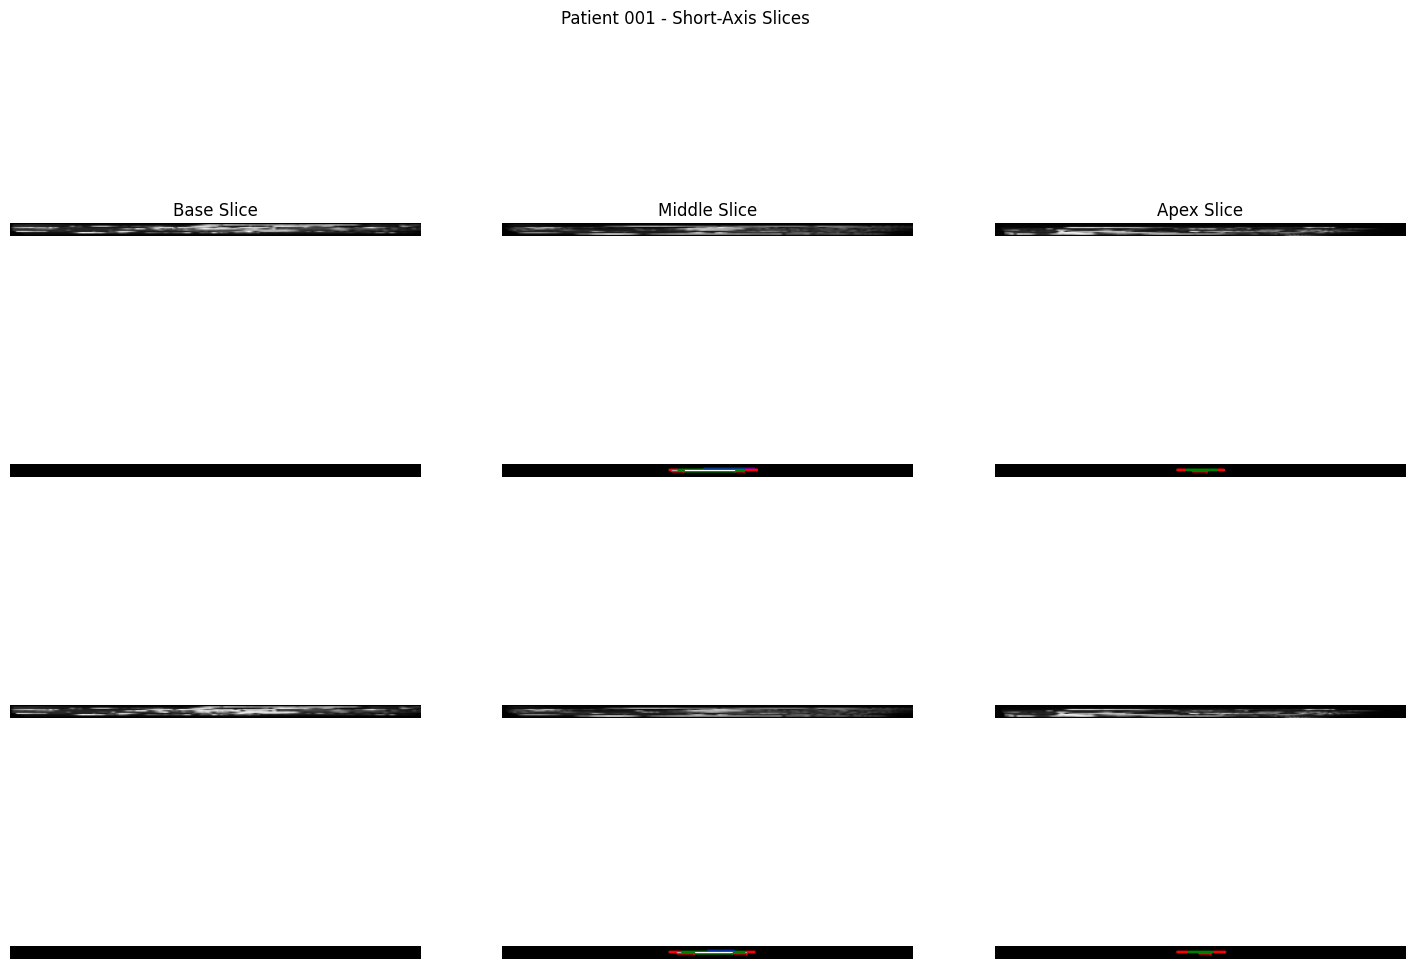

In [139]:
def visualize_patient(patient_id, dataset_type):
    patient_folder = os.path.join(OUTPUT_DIR, dataset_type, f"patient{patient_id:03d}")
    files = {
        "ED": f"patient{patient_id:03d}_ED_processed.nii.gz",
        "ED_gt": f"patient{patient_id:03d}_ED_gt_processed.nii.gz",
        "ES": f"patient{patient_id:03d}_ES_processed.nii.gz",
        "ES_gt": f"patient{patient_id:03d}_ES_gt_processed.nii.gz",
    }
    
    images = {key: nib.load(os.path.join(patient_folder, path)).get_fdata() 
              for key, path in files.items() if os.path.exists(os.path.join(patient_folder, path))}
    
    slice_positions = {
        "Base": 1,
        "Middle": images["ED"].shape[2] // 2,
        "Apex": images["ED"].shape[2] - 2,
    }
    
    fig, axes = plt.subplots(len(images), 3, figsize=(18, 12))
    colors = {1: "blue", 2: "red", 3: "green"}  # LVC, RVC, LVM
    
    for row_idx, (key, img) in enumerate(images.items()):
        for col_idx, (pos, z) in enumerate(slice_positions.items()):
            ax = axes[row_idx, col_idx]
            ax.imshow(img[:, :, z], cmap="gray")
            if "_gt" in key:
                for class_id in [1, 2, 3]:
                    contours = measure.find_contours(img[:, :, z] == class_id, 0.5)
                    for contour in contours:
                        ax.plot(contour[:, 1], contour[:, 0], colors[class_id], linewidth=1)
            ax.axis("off")
            if row_idx == 0:
                ax.set_title(f"{pos} Slice")
        axes[row_idx, 0].set_ylabel(key, rotation=90, fontsize=12)
    
    plt.suptitle(f"Patient {patient_id:03d} - Short-Axis Slices")
    plt.show()

visualize_patient(1, "training")